In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import missingno as msn

In [5]:
machine = pd.read_csv('machine.data_update.csv')
machine.columns = ['vendor_name', 'model', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP']

In [6]:
print(machine.head())
print(machine.info())
print(machine.shape)
print(machine.columns)

  vendor_name    model  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0     adviser    32/60   125   256   6000   256     16    128  198  199
1      amdahl   470v/7    29  8000  32000    32      8     32  269  253
2      amdahl  470v/7a    29  8000  32000    32      8     32  220  253
3      amdahl  470v/7b    29  8000  32000    32      8     32  172  253
4      amdahl  470v/7c    29  8000  16000    32      8     16  132  132
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   vendor_name  209 non-null    object
 1   model        209 non-null    object
 2   MYCT         209 non-null    int64 
 3   MMIN         209 non-null    int64 
 4   MMAX         209 non-null    int64 
 5   CACH         209 non-null    int64 
 6   CHMIN        209 non-null    int64 
 7   CHMAX        209 non-null    int64 
 8   PRP          209 non-null    int64 
 9   ERP    

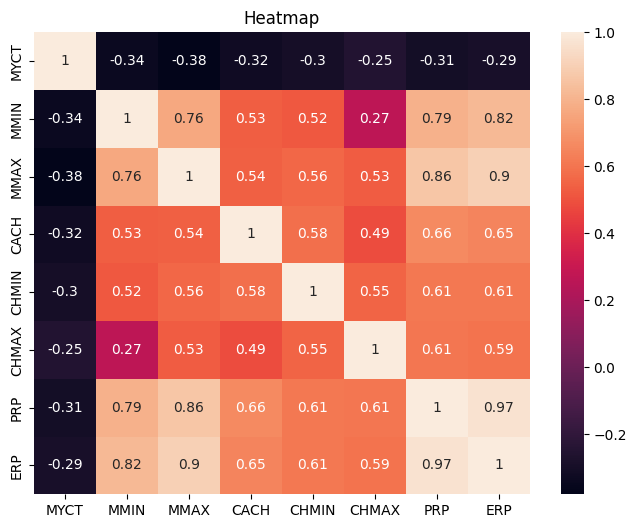

In [7]:
plt.figure(figsize=(8, 6)) # 데이터 시각화, 탐색
numeric_features = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP']
sns.heatmap(machine[numeric_features].astype(float).corr(), annot=True) # 상관관계 시각화 : 히트맵
plt.title('Heatmap')
plt.show()

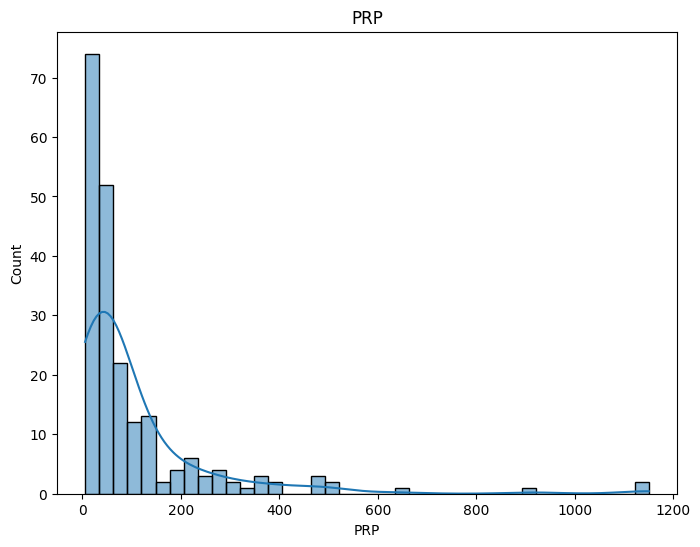

In [8]:
plt.figure(figsize=(8, 6)) 
sns.histplot(machine['PRP'], kde=True) # 타겟 변수 PRP
plt.title('PRP')
plt.show()

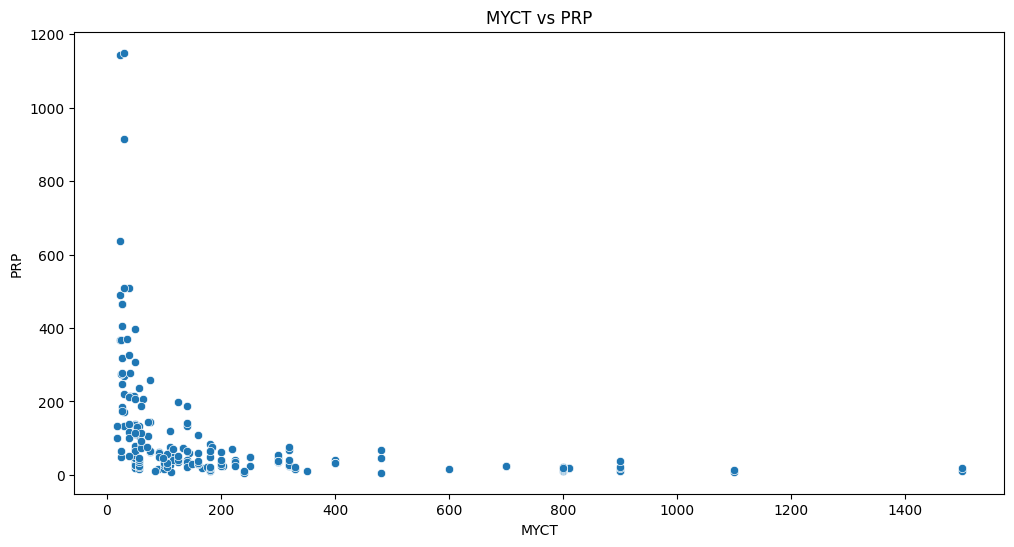

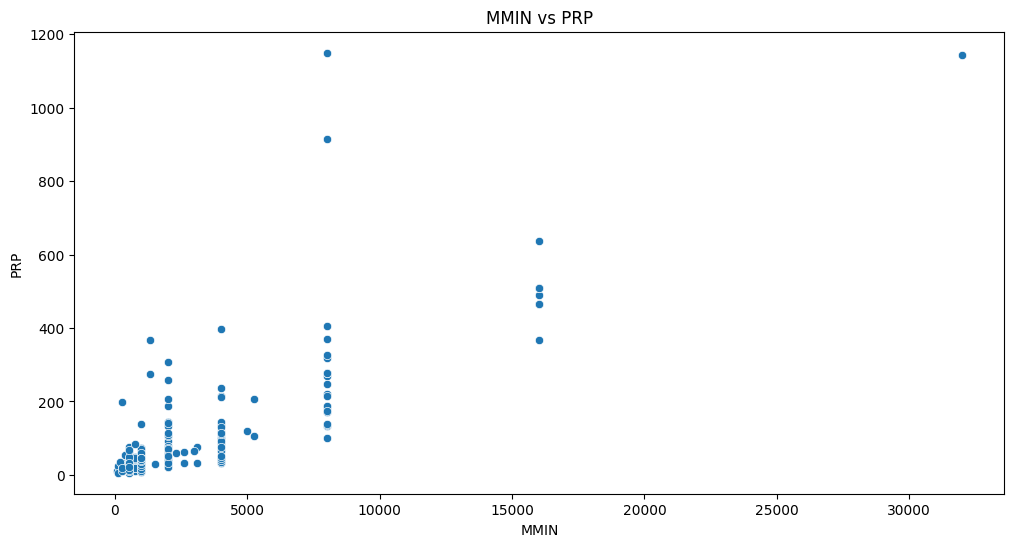

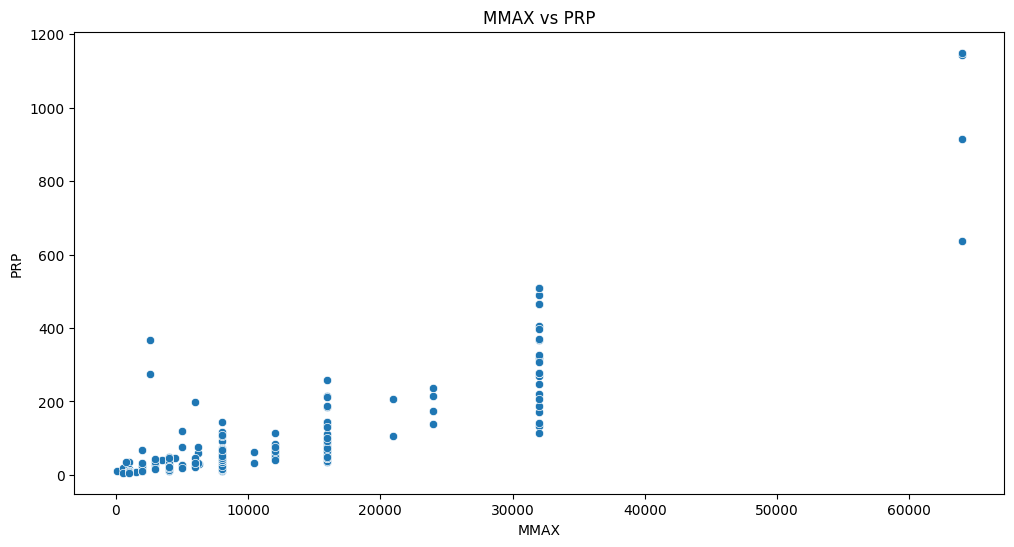

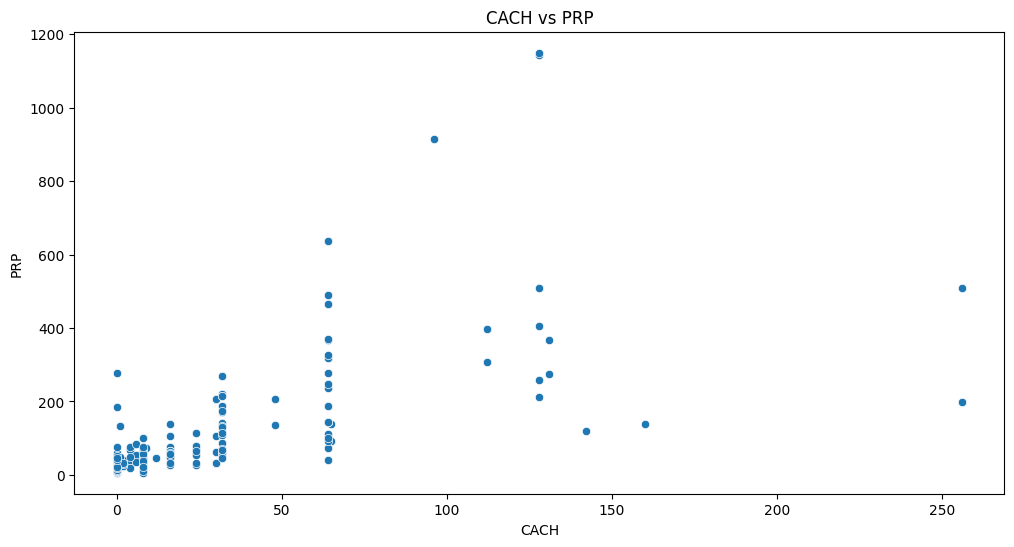

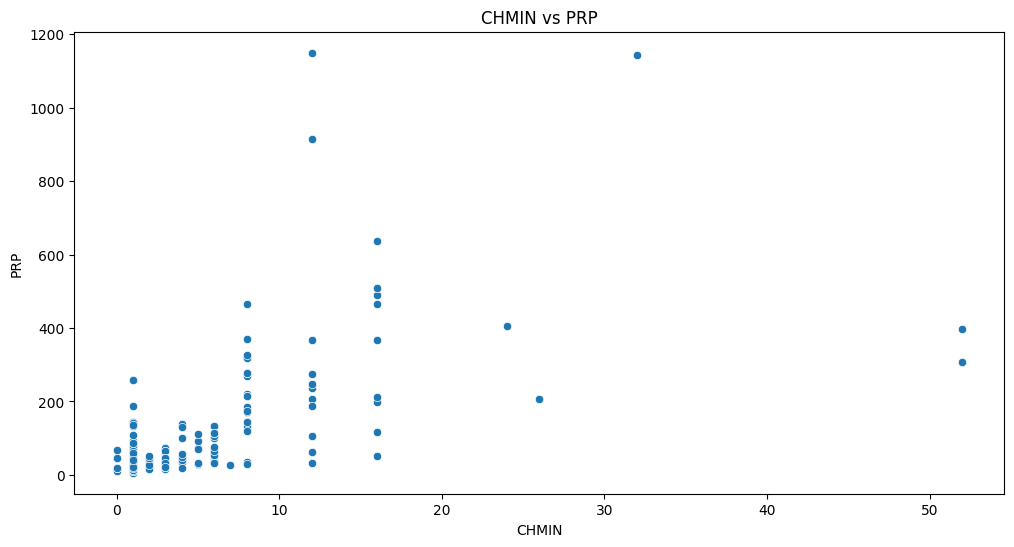

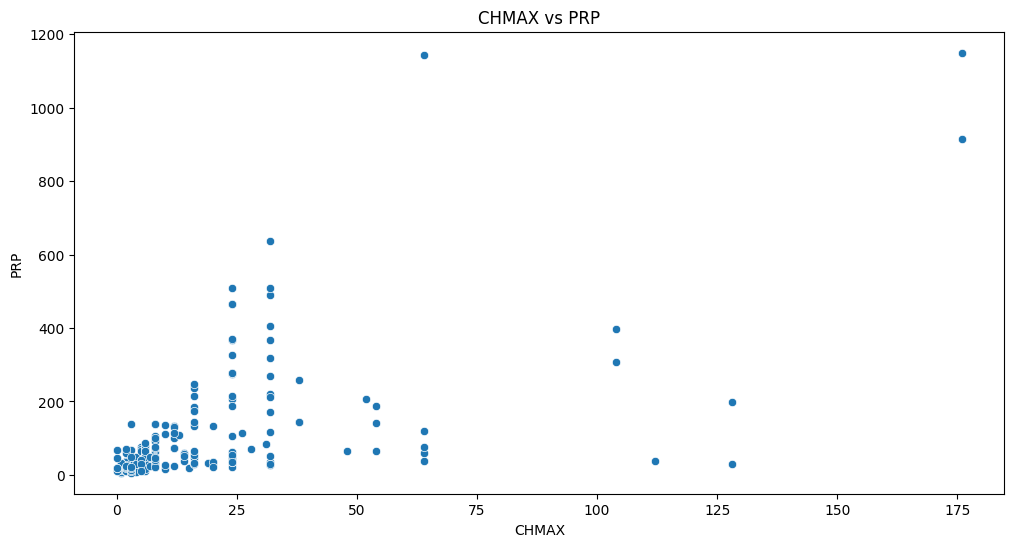

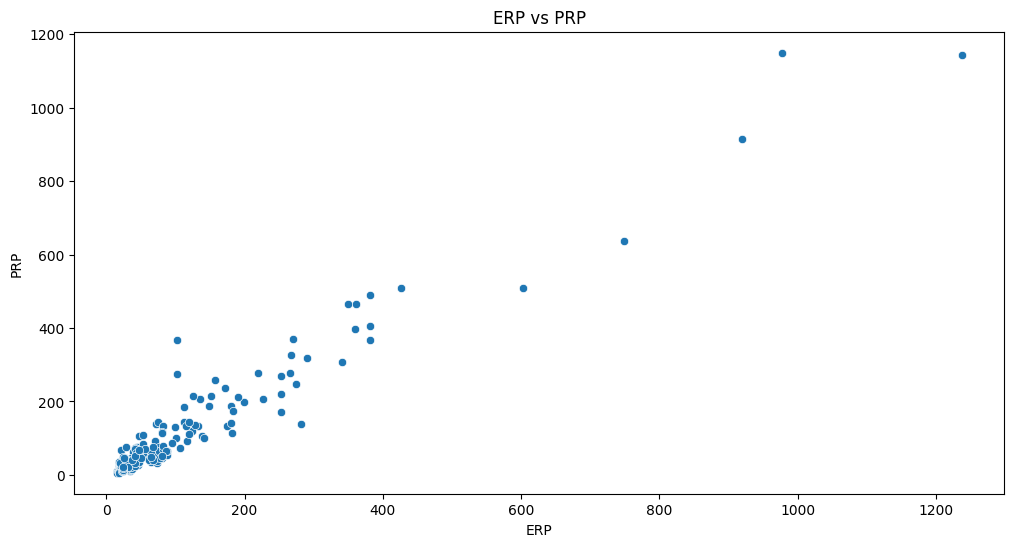

In [9]:
features = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'ERP']
for feature in features:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=machine[feature], y=machine['PRP']) # 피처, 타겟 변수 'PRP'와의 관계 시각화
    plt.title(f'{feature} vs PRP')
    plt.show()

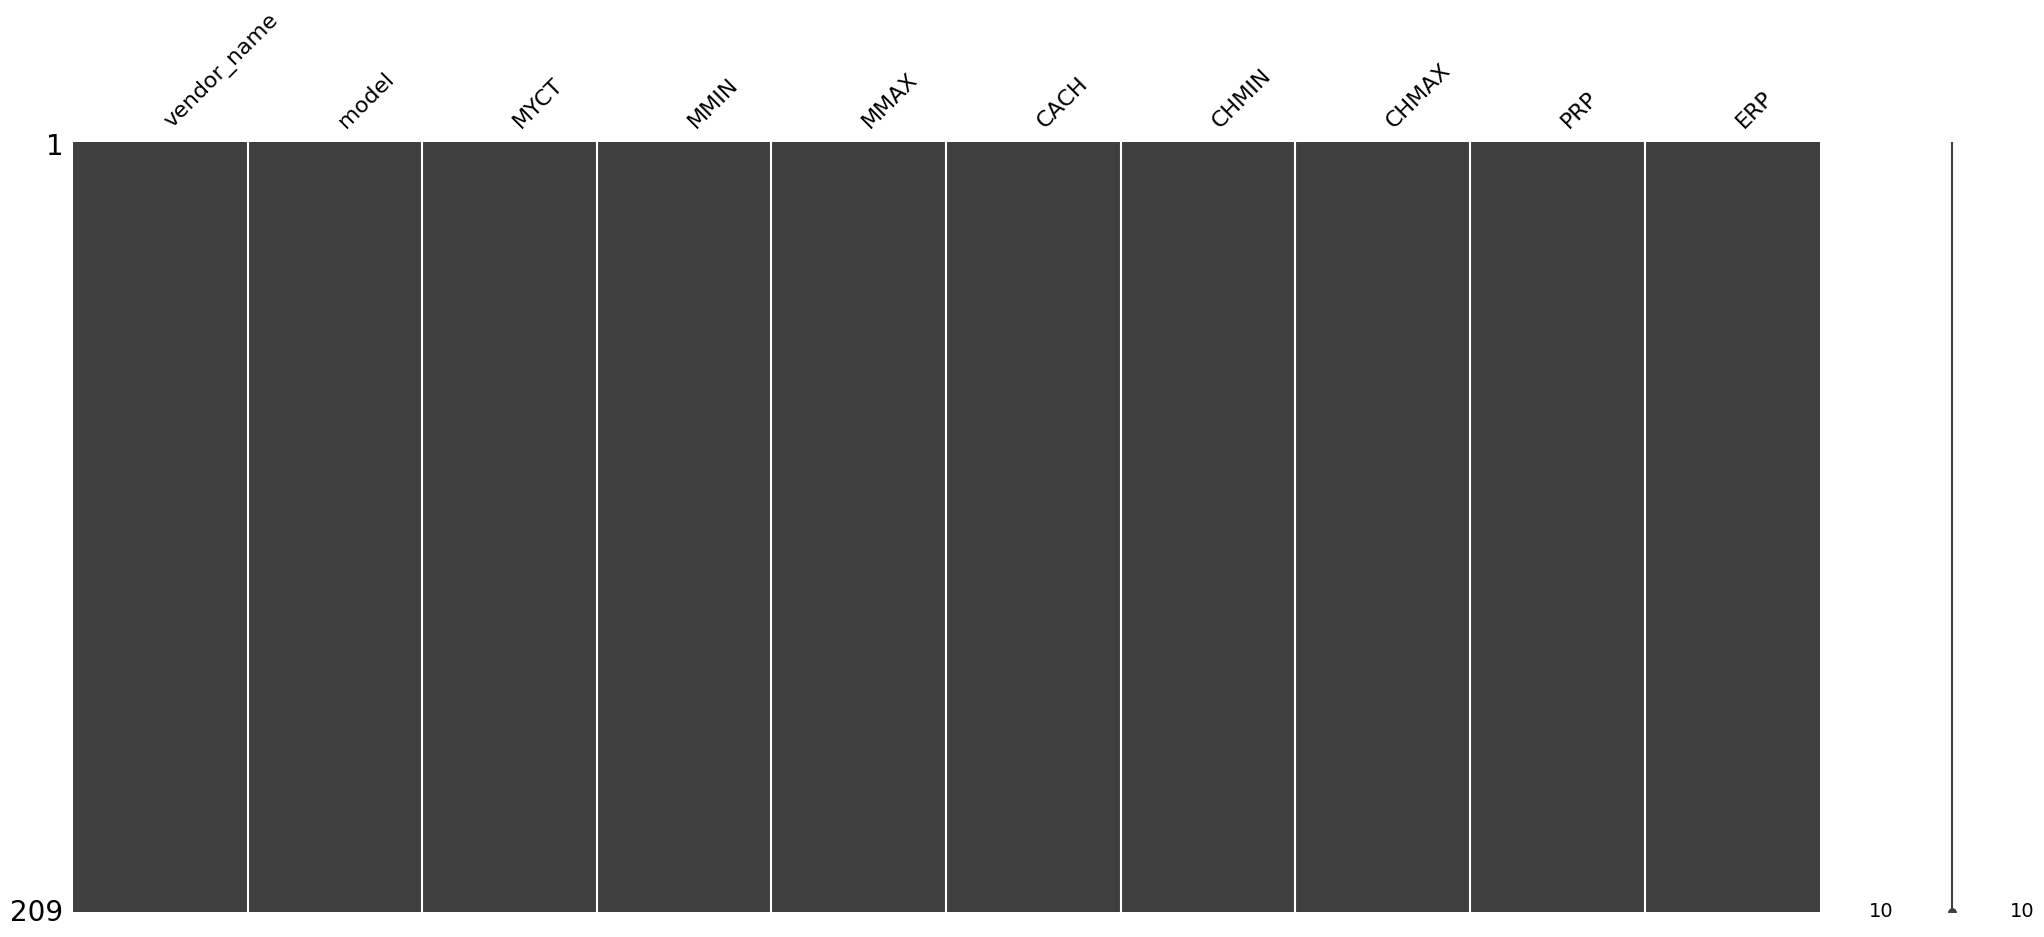

In [10]:
msn.matrix(machine) # 결측값 시각화
plt.show()

In [11]:
print(machine.isnull().sum()) # 결측값 확인

vendor_name    0
model          0
MYCT           0
MMIN           0
MMAX           0
CACH           0
CHMIN          0
CHMAX          0
PRP            0
ERP            0
dtype: int64


In [12]:
X = machine[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'ERP']] 
y = machine['PRP'] # 데이터 전처리

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
linear_model = LinearRegression() # 다중 선형 회귀 모델 학습
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    return train_r2, test_r2, test_mse, test_mae

In [16]:
# 모델 평가
train_r2, test_r2, test_mse, test_mae = evaluate_model(linear_model, X_train_scaled, X_test_scaled, y_train, y_test)
print(f"Training R-squared: {train_r2}")
print(f"Test R-squared: {test_r2}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean Absolute Error: {test_mae}")

Training R-squared: 0.9301804408244846
Test R-squared: 0.9121642358923813
Test Mean Squared Error: 3982.1392683109757
Test Mean Absolute Error: 33.683599862364794


In [17]:
cv_scores = cross_val_score(linear_model, X, y, cv=5) # 교차 검증
print(f"Cross-validation R-squared: {cv_scores.mean()}")

ridge = Ridge(alpha=1.0) # Ridge 모델 개선
ridge.fit(X_train_scaled, y_train)
ridge_r2 = r2_score(y_test, ridge.predict(X_test_scaled))
print(f"Ridge Regression R-squared: {ridge_r2}")

lasso = Lasso(alpha=0.1)  # Lasso Regression 모델 개선
lasso.fit(X_train_scaled, y_train)
lasso_r2 = r2_score(y_test, lasso.predict(X_test_scaled))
print(f"Lasso Regression R-squared: {lasso_r2}")

Cross-validation R-squared: 0.8333737813606052
Ridge Regression R-squared: 0.9018316291828352
Lasso Regression R-squared: 0.9120730538643171


In [18]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]} #하이퍼파라미터 튜닝
best_ridge = GridSearchCV(Ridge(), param_grid, cv=5).fit(X_train_scaled, y_train).best_estimator_
best_ridge_r2 = r2_score(y_test, best_ridge.predict(X_test_scaled))
print(f"Best Ridge Regression R-squared: {best_ridge_r2}")

Best Ridge Regression R-squared: 0.8421904719481014


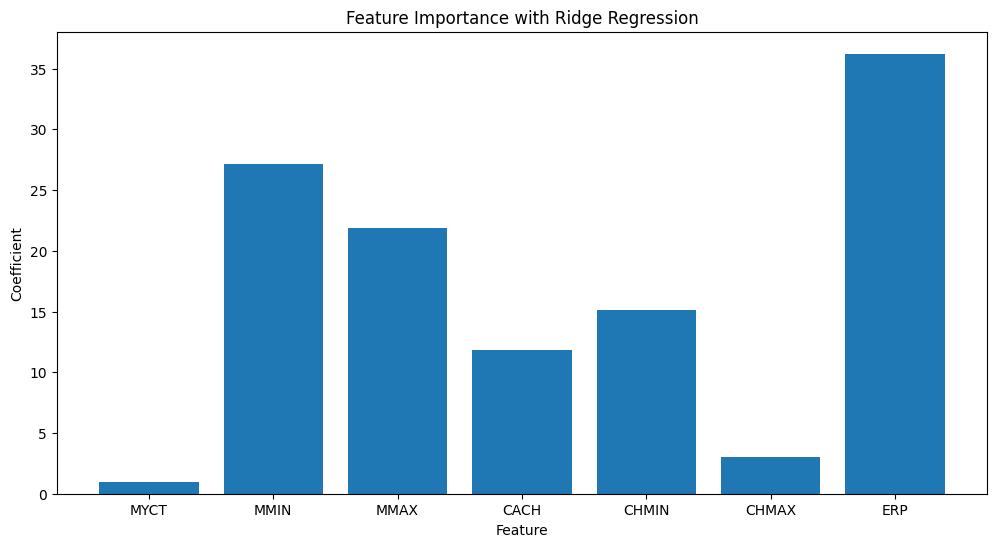

In [19]:
plt.figure(figsize=(12, 6)) # 중요도 시각화 (Ridge 모델 기준)
plt.bar(features, best_ridge.coef_)
plt.title('Feature Importance with Ridge Regression')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.show()

In [20]:
# ERP 피처 제외한 모델 성능 비교
X_features = machine[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']]
X_train_features, X_test_features, y_train_features, y_test_features = train_test_split(X_features, y, test_size=0.2, random_state=42)
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

In [22]:
linear_model_X_features = LinearRegression()
linear_model_X_features.fit(X_train_features_scaled, y_train_features)

LinearRegression()

In [24]:
train_r2_X_features, test_r2_X_features, test_mse_X_features, test_mae_X_features = evaluate_model(linear_model_X_features, X_train_features_scaled, X_test_features_scaled, y_train_features, y_test_features)
print(f"Training R-squared without ERP: {train_r2_X_features}")
print(f"Test R-squared without ERP: {test_r2_X_features}")
print(f"Test Mean Squared Error without ERP: {test_mse_X_features}")
print(f"Test Mean Absolute Error without ERP: {test_mae_X_features}")

Training R-squared without ERP: 0.8378284557995717
Test R-squared without ERP: 0.8893455830696775
Test Mean Squared Error without ERP: 5633.068155793253
Test Mean Absolute Error without ERP: 48.068801347004765


In [25]:
cv_scores_no_erp = cross_val_score(linear_model_no_erp, X_no_erp, y, cv=5) # ERP피처 제외 교차 검증 
print(f"Cross-validation R-squared without ERP: {cv_scores_no_erp.mean()}")

Cross-validation R-squared without ERP: 0.6162337806164541
